# Previous settings
### This section contains 3 cells. The necessary packages used later are imported. The routes to import the dataset, save pictures and export trained models are defined. And some functions used to train models, obtain model’s scores and draw pictures are defined. These functions are used later to simplify the processes of training models.

In [11]:
# Make the following code support python2 and python3
from __future__ import division, print_function, unicode_literals

# Check if the version of python is 3.5 and above
import sys
assert sys.version_info >= (3, 5)

# Check to see if sklearn is version 0.20 and above
import sklearn
assert sklearn.__version__ >= "0.20"

import numpy as np
import pandas as pd
import os 

# The result obtained after each run is the same as that of this notebook
np.random.seed(42) 

# Make matplotlib diagrams work better
%matplotlib inline
import matplotlib as mpl
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Setting the route to save the image
PROJECT_ROOT_DIR = "."
IMAGE_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGE_PATH, exist_ok=True)

# Setting the route to save the model
MODEL_PATH = os.path.join(PROJECT_ROOT_DIR, "models")
os.makedirs(MODEL_PATH, exist_ok=True)

# Setting the route to read the data set
DATA_PATH = os.path.join(PROJECT_ROOT_DIR, "datasets")

# Define a function to automatically store the picture
def save_fig(fig_id, tight_layout=True):
    '''
    Run to save automatic pictures
    
    :param fig_id: image name
    '''
    path = os.path.join(PROJECT_ROOT_DIR, "images", fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=600)

# Suppress the warning caused by sklearn
import warnings
warnings.filterwarnings('ignore')

In [12]:
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
import joblib

# Define a function to train the model, output the model's scores and automatically store the trained model
def score(model, model_name, pkl_name, X_train, X_test, y_train, y_test):
    """gain the R2 and RMSE score of the model
    
    :param model: ML model from sklearn package
    :param model_name: string, the name input
    :param X_train: data set used for training
    :param X_test: data set used for predicting
    :param y_train: the labels of training data set
    :param y_test: the labels of testing data set
    """
    global MODEL_PATH, PROJECT_ROOT_DIR
    
    # Train the model
    model.fit(X_train, y_train)
    y_train_predict = model.predict(X_train)
    y_test_predict = model.predict(X_test)
    
    # Obtain the model's scores and output them
    train_rmse = np.around(np.sqrt(mean_squared_error(y_train, y_train_predict)), decimals=3)
    test_rmse = np.around(np.sqrt(mean_squared_error(y_test, y_test_predict)), decimals=3)
    train_r2 = np.around(r2_score(y_train, y_train_predict), decimals=3)
    test_r2 = np.around(r2_score(y_test, y_test_predict), decimals=3)
    print('-'*10 + model_name + '-'*10)
    print("The RMSE on training set is {}".format(train_rmse))
    print("The RMSE on test set is {}".format(test_rmse))
    print("R2 score on training set is {}".format(train_r2))
    print("R2 score on test set is {}".format(test_r2))
    
    # Store the trained model in a specific directory "models"
    path = os.path.join(PROJECT_ROOT_DIR, "models", pkl_name + ".pkl")
    joblib.dump(model, path)
    print("Successfully store the trained model in {}.pkl".format(pkl_name))
    
    return y_train_predict, y_test_predict, train_rmse, test_rmse, train_r2, test_r2        

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Define a function to draw a binary graph that compares the reference and regression values of the training and test sets
def binary_plot(y_train,  y_train_label, y_test, y_test_label,
                train_rmse, test_rmse, train_r2, test_r2,
                text_position=[1.1, 0.15]):
    """plot the binary diagram
    
    :param y_train: the label of the training data set
    :param y_train_label: the prediction of the training the data set
    :param y_test: the label of the testing data set
    :param y_test_label: the prediction of the testing data set
    :param train_rmse: the RMSE score of the training data set
    :param test_rmse: the RMSE score of the testing data set
    :param train_r2: the R2 score of the training data set
    :param test_r2: the R2 score of the testing data set
    :param test_position: the coordinates of R2 text for
    """
    
    plt.figure(figsize=(8,8))
    a=[0,2]; b=[0,2]
    plt.plot(a, b, c='red',linewidth=1.5)
    plt.scatter(y_train, y_train_label, marker="s", c='#3399FF', edgecolors='black',linewidths=0.5,
                label="Training set-RMSE={}".format(train_rmse))
    plt.scatter(y_test, y_test_label, marker="o", c='#FFFF00', edgecolors='black',linewidths=0.5,
                label="Test set-RMSE={}".format(test_rmse))
    plt.legend(loc="upper left", fontsize=14)
    plt.xlabel("Reference H2O concentration (wt.%)", fontsize=20)
    plt.ylabel("Predicted H2O concentration (wt.%)", fontsize=20)
    plt.text(text_position[0], text_position[1]+0.08,
             r'$R^2(train)=${}'.format(train_r2),
             fontdict={'size': 16, 'color': '#000000'})
    plt.text(text_position[0], text_position[1]-0.08,
             r'$R^2(test)=${}'.format(test_r2),
             fontdict={'size': 16, 'color': '#000000'})
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

# Data reading and preprocessing
### This section contains 3 cells. The filtered dataset ‘dataset1.xlsx’, consisting of compiled MORB glasses with measured water contents, is imported from the secondary directory ‘datasets’. Then samples are labelled following the rules introduced in the section 2.2 of the main text. Next, the feature element compositions (major elements SiO2, TiO2, Al2O3, FeOT, MgO, CaO, Na2O, K2O, and trace elements Rb, Sr, Nb, Ba, La, Ce, Nd, Sm, Eu, Yb, Hf, Pb, Th, U) are extracted to ‘X_all’ and the target element compositions (H2O) are extracted to ‘y_all’, to prepare for the later model training.

In [14]:
# Read the excel of the data
data_train = os.path.join(DATA_PATH,"dataset1.xlsx")
df1 = pd.read_excel(data_train)
df1

,H2O,SiO2,TiO2,Al2O3,FeO*,MgO,CaO,Na2O,K2O,Rb,...,La,Ce,Nd,Sm,Eu,Yb,Hf,Pb,Th,U
0,0.716277,51.3000,2.0400,14.2500,11.7100,5.220,10.1200,3.08,0.7900,24.588408,...,22.844890,47.982161,25.007304,5.664748,1.843823,3.279354,3.627418,1.366802,2.353031,0.691701
1,0.701691,50.9800,1.9900,14.5400,11.5100,5.140,10.0900,3.07,0.7600,23.186733,...,22.379894,46.126541,23.823740,5.238316,1.732271,3.215170,3.425327,1.334652,2.514311,0.655611
2,0.754821,51.1300,2.0100,14.5000,11.6700,5.160,10.1500,2.99,0.7600,23.851576,...,21.854267,46.821369,23.816139,5.317914,1.711206,3.089082,3.432680,1.354839,2.323063,0.660840
3,0.755673,51.0800,1.9600,13.9500,11.5700,5.190,10.1500,3.02,0.7500,23.408761,...,22.464431,46.162491,23.802306,5.190984,1.762733,3.167629,3.420601,1.302290,2.390631,0.615380
4,0.104372,50.9700,0.8100,14.4600,9.9700,7.940,13.0600,1.72,0.0500,0.855594,...,1.166213,3.667440,3.836289,1.553572,0.636368,2.121664,0.997147,0.187390,0.068686,0.022263
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1462,0.867000,48.9100,3.0200,14.5900,11.3200,6.080,11.3500,3.10,0.5200,5.678100,...,14.392400,36.148200,24.369300,6.420700,1.935900,2.732600,5.069900,1.785000,0.984600,0.358100
1463,0.839000,49.0700,3.5000,13.8600,12.2900,5.380,11.3100,3.32,0.6300,7.077300,...,17.760900,44.622400,29.166800,7.283000,2.460000,3.235700,6.269800,1.825300,1.261900,0.453900
1464,1.033000,48.8500,3.2300,14.4800,11.3400,6.280,11.5000,3.22,0.5200,6.760000,...,15.180000,40.940000,26.650000,6.800000,2.390000,2.770000,5.360000,1.370000,1.010000,0.382000
1465,1.231700,48.9500,4.3000,13.2800,13.8100,4.900,9.5900,3.67,0.7400,10.148900,...,21.966600,59.369400,37.191300,9.249600,3.133400,3.771500,7.585200,1.922800,1.516300,0.611600


In [15]:
# Label all data
labels = []
H2O = list(df1["H2O"])
Ce = list(df1["Ce"])
for i in range(len(H2O)):
    t = H2O[i]*10000/Ce[i]
    if H2O[i] <= 0.3 and t <= 400:       
        labels.append(1)
    elif H2O[i] <= 0.6 and t <= 400:
        labels.append(2)    
    elif H2O[i] <= 1 and t <= 400:
        labels.append(3)
    elif H2O[i] <= 1.4 and t <= 400:
        labels.append(4)
    elif t <= 400:
        labels.append(5)
    else:
        labels.append(6)
df1["labels"] = labels
df1

,H2O,SiO2,TiO2,Al2O3,FeO*,MgO,CaO,Na2O,K2O,Rb,...,Ce,Nd,Sm,Eu,Yb,Hf,Pb,Th,U,labels
0,0.716277,51.3000,2.0400,14.2500,11.7100,5.220,10.1200,3.08,0.7900,24.588408,...,47.982161,25.007304,5.664748,1.843823,3.279354,3.627418,1.366802,2.353031,0.691701,3
1,0.701691,50.9800,1.9900,14.5400,11.5100,5.140,10.0900,3.07,0.7600,23.186733,...,46.126541,23.823740,5.238316,1.732271,3.215170,3.425327,1.334652,2.514311,0.655611,3
2,0.754821,51.1300,2.0100,14.5000,11.6700,5.160,10.1500,2.99,0.7600,23.851576,...,46.821369,23.816139,5.317914,1.711206,3.089082,3.432680,1.354839,2.323063,0.660840,3
3,0.755673,51.0800,1.9600,13.9500,11.5700,5.190,10.1500,3.02,0.7500,23.408761,...,46.162491,23.802306,5.190984,1.762733,3.167629,3.420601,1.302290,2.390631,0.615380,3
4,0.104372,50.9700,0.8100,14.4600,9.9700,7.940,13.0600,1.72,0.0500,0.855594,...,3.667440,3.836289,1.553572,0.636368,2.121664,0.997147,0.187390,0.068686,0.022263,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1462,0.867000,48.9100,3.0200,14.5900,11.3200,6.080,11.3500,3.10,0.5200,5.678100,...,36.148200,24.369300,6.420700,1.935900,2.732600,5.069900,1.785000,0.984600,0.358100,3
1463,0.839000,49.0700,3.5000,13.8600,12.2900,5.380,11.3100,3.32,0.6300,7.077300,...,44.622400,29.166800,7.283000,2.460000,3.235700,6.269800,1.825300,1.261900,0.453900,3
1464,1.033000,48.8500,3.2300,14.4800,11.3400,6.280,11.5000,3.22,0.5200,6.760000,...,40.940000,26.650000,6.800000,2.390000,2.770000,5.360000,1.370000,1.010000,0.382000,4
1465,1.231700,48.9500,4.3000,13.2800,13.8100,4.900,9.5900,3.67,0.7400,10.148900,...,59.369400,37.191300,9.249600,3.133400,3.771500,7.585200,1.922800,1.516300,0.611600,4


In [16]:
# Extract the eigenvalue X and the target value y
X_all = df1.drop(["H2O","labels"], axis=1)
y_all = df1["H2O"].copy()
X_all

,SiO2,TiO2,Al2O3,FeO*,MgO,CaO,Na2O,K2O,Rb,Sr,...,La,Ce,Nd,Sm,Eu,Yb,Hf,Pb,Th,U
0,51.3000,2.0400,14.2500,11.7100,5.220,10.1200,3.08,0.7900,24.588408,256.281304,...,22.844890,47.982161,25.007304,5.664748,1.843823,3.279354,3.627418,1.366802,2.353031,0.691701
1,50.9800,1.9900,14.5400,11.5100,5.140,10.0900,3.07,0.7600,23.186733,238.513892,...,22.379894,46.126541,23.823740,5.238316,1.732271,3.215170,3.425327,1.334652,2.514311,0.655611
2,51.1300,2.0100,14.5000,11.6700,5.160,10.1500,2.99,0.7600,23.851576,246.917072,...,21.854267,46.821369,23.816139,5.317914,1.711206,3.089082,3.432680,1.354839,2.323063,0.660840
3,51.0800,1.9600,13.9500,11.5700,5.190,10.1500,3.02,0.7500,23.408761,253.076379,...,22.464431,46.162491,23.802306,5.190984,1.762733,3.167629,3.420601,1.302290,2.390631,0.615380
4,50.9700,0.8100,14.4600,9.9700,7.940,13.0600,1.72,0.0500,0.855594,62.070754,...,1.166213,3.667440,3.836289,1.553572,0.636368,2.121664,0.997147,0.187390,0.068686,0.022263
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1462,48.9100,3.0200,14.5900,11.3200,6.080,11.3500,3.10,0.5200,5.678100,381.852000,...,14.392400,36.148200,24.369300,6.420700,1.935900,2.732600,5.069900,1.785000,0.984600,0.358100
1463,49.0700,3.5000,13.8600,12.2900,5.380,11.3100,3.32,0.6300,7.077300,364.429800,...,17.760900,44.622400,29.166800,7.283000,2.460000,3.235700,6.269800,1.825300,1.261900,0.453900
1464,48.8500,3.2300,14.4800,11.3400,6.280,11.5000,3.22,0.5200,6.760000,391.620000,...,15.180000,40.940000,26.650000,6.800000,2.390000,2.770000,5.360000,1.370000,1.010000,0.382000
1465,48.9500,4.3000,13.2800,13.8100,4.900,9.5900,3.67,0.7400,10.148900,361.992900,...,21.966600,59.369400,37.191300,9.249600,3.133400,3.771500,7.585200,1.922800,1.516300,0.611600


# Model Training
### This section contains 3 cells. The dataset is divided into a training set (n=1,320), used to train the model, and a test set (n=147), not involved in model training and used to evaluate the model. The Random Forest Regression model is trained by the training set and then exported to the secondary directory ‘models’ with a file extension of ‘.pkl’. The binary diagram is drawn and saved in the secondary directory ‘images’ simultaneously.

In [17]:
from sklearn.model_selection import StratifiedShuffleSplit

# Stratified random sampling
split_rf = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=128)
for train_index, test_index in split_rf.split(df1,df1["labels"]):
    # train : test = 4 : 1
    X_train = X_all.loc[train_index]
    X_test = X_all.loc[test_index] 
    y_train = y_all.loc[train_index]
    y_test = y_all.loc[test_index]

----------Random Forest----------
The RMSE on training set is 0.06
The RMSE on test set is 0.071
R2 score on training set is 0.932
R2 score on test set is 0.909
Successfully store the trained model in rf.pkl
Saving figure rf_1


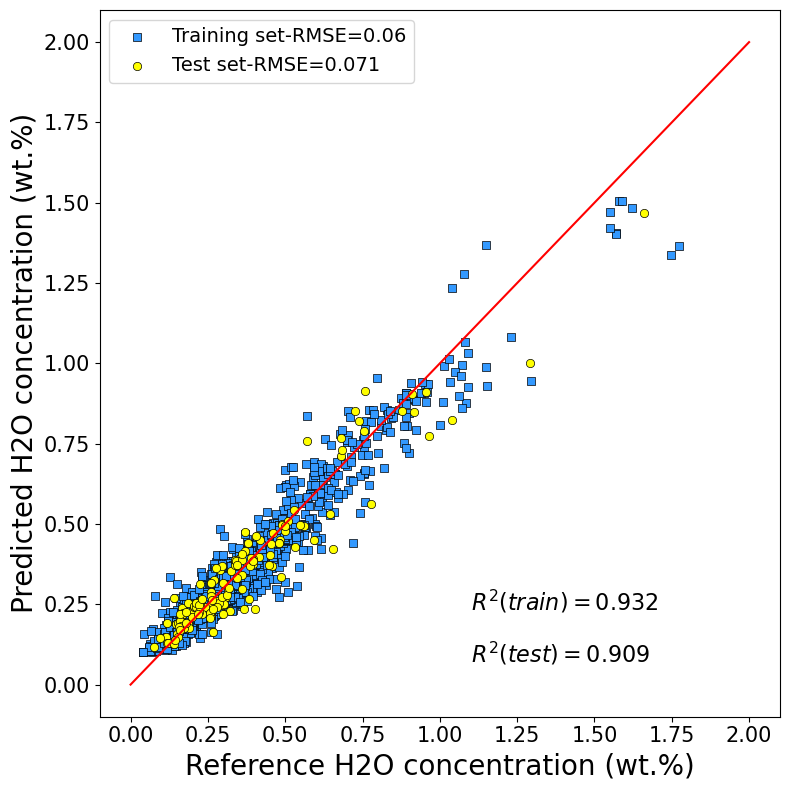

In [18]:
from sklearn.ensemble import RandomForestRegressor

# Set the hyperparameters of the Random Forest Regression model
rf=RandomForestRegressor(n_estimators=125, min_samples_split=2, min_samples_leaf=3, max_features='sqrt', \
                         max_depth=17, max_leaf_nodes=70, random_state=2022)

# Use the defined function to train the model and get the scores of both the training and the test set
y_train_predict, y_test_predict, train_rmse, test_rmse, train_r2, test_r2 = \
    score(rf, 'Random Forest', 'rf', X_train, X_test, y_train, y_test)

# Plot binary diagram
binary_plot(y_train = y_train,
            y_train_label = y_train_predict,
            y_test = y_test,
            y_test_label = y_test_predict,
            train_rmse = train_rmse,
            test_rmse = test_rmse,
            train_r2 = train_r2,
            test_r2 = test_r2)

# Save the figure
save_fig("rf_1")